# Feature engineering

## imports de biblioteca e data set

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import os


In [13]:
# 1. Carregar os dados de TREINO 
df_train = pd.read_csv('../data/train.csv')

# 2. Carregar os dados de TESTE
df_test = pd.read_csv('../data/test.csv')

## 1 - limpeza de dados

**Na etapa de Feature Engineering, optou-se por não realizar a remoção de outliers ou a imputação de dados. Como verificado anteriormente, o dataset não apresenta valores faltantes (NaN), o que elimina a necessidade de preenchimento. Quanto aos valores atípicos, em problemas de detecção de anomalias, o comportamento fraudulento manifesta-se precisamente através desses desvios estatísticos. Remover outliers neste contexto significaria eliminar as evidências mais fortes de fraude, reduzindo a capacidade do modelo de aprender as características de transações suspeitas. Portanto, manteremos a integridade dos dados para garantir que o algoritmo capture essas irregularidades.**

## 2 - Criação e transformação de features

### 2.1 - transformação da coluna Time para Hour (hora do dia em formato seno e cosseno)

**A transformação da variável original Time (segundos acumulados) para o formato de Hora do Dia e, posteriormente, para componentes de Seno e Cosseno, foi fundamental para capturar a natureza cíclica do comportamento humano. Diferente de uma escala linear, onde as horas 23 e 0 estão numericamente distantes, a transformação trigonométrica permite que o modelo compreenda que o final de um dia e o início de outro são cronologicamente adjacentes. Essa engenharia de atributos é estratégica para isolar padrões de risco, como o aumento relativo de fraudes durante a madrugada, permitindo que o algoritmo identifique anomalias baseadas não apenas no 'quê', mas no 'quando' a transação ocorre.**

In [14]:
# Converter Segundos em Hora do Dia
if 'Time' in df_train.columns:
    df_train['Hour'] = df_train['Time'].apply(lambda x: np.floor(x / 3600) % 24)

    df_test['Hour'] = df_test['Time'].apply(lambda x: np.floor(x / 3600) % 24)

In [15]:
# Converter Hora do Dia em Variáveis Cíclicas
if 'Hour' in df_train.columns:
    df_train['Hour_Sin'] = np.sin(2 * np.pi * df_train['Hour'] / 24)

    df_train['Hour_Cos'] = np.cos(2 * np.pi * df_train['Hour'] / 24)

### 2.2 - categorização do valor da transação

**A categorização do Amount em 8 níveis discretos foi implementada para capturar a natureza não linear e multimodal do risco de fraude. Diferente de variáveis convencionais, o valor da transação não apresenta um crescimento de risco constante; ele oscila em 'picos' de atividade criminosa. Ao realizarmos essa estratificação, permitimos que o modelo identifique padrões distintos: o Nível 1 (0 a 1) isola o comportamento técnico de verificação de cartões, enquanto o Nível 6 (1000 a 1500) revela um ponto crítico de ataques de alto valor (0,46% de taxa). Essa engenharia transforma o ruído estatístico dos outliers em sinais preditivos claros, mapeando onde a fraude se camufla e onde ela é inexistente, como na 'Zona de Segurança' acima de $2.500.**

In [16]:
# Definindo cortes manuais baseados na distribuição real dos dados e quanto eles contribuiam para a porcentagem de fraudes
cortes_finais = [0, 1, 80, 100, 750, 1000, 1500, 2500, df_train['Amount'].max()]
labels_risco = [1, 2, 3, 4, 5, 6, 7, 8]

df_train['Amount_Risk_Level'] = pd.cut(df_train['Amount'], 
                                         bins=cortes_finais, 
                                         labels=labels_risco, 
                                         include_lowest=True).astype(int)

# Verificação da eficiência
analise = df_train.groupby('Amount_Risk_Level')['Class'].agg(['count', 'mean']).reset_index()
analise.columns = ['Nível de Risco', 'Total Transações', 'Taxa de Fraude (%)']
analise['Taxa de Fraude (%)'] *= 100
print(analise)

   Nível de Risco  Total Transações  Taxa de Fraude (%)
0               1             24320            0.596217
1               2            148569            0.076732
2               3              9664            0.300083
3               4             41351            0.222486
4               5              1609            0.372902
5               6              1277            0.469851
6               7               712            0.280899
7               8               343            0.000000


### Verificar se as mudanças foram feitas corretamente

In [17]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 227845 non-null  int64  
 1   Time               227845 non-null  float64
 2   V1                 227845 non-null  float64
 3   V2                 227845 non-null  float64
 4   V3                 227845 non-null  float64
 5   V4                 227845 non-null  float64
 6   V5                 227845 non-null  float64
 7   V6                 227845 non-null  float64
 8   V7                 227845 non-null  float64
 9   V8                 227845 non-null  float64
 10  V9                 227845 non-null  float64
 11  V10                227845 non-null  float64
 12  V11                227845 non-null  float64
 13  V12                227845 non-null  float64
 14  V13                227845 non-null  float64
 15  V14                227845 non-null  float64
 16  V15          

## 3 - Remoção de colunas não utilizadas

### 3.1 - remoção de colunas originais do data set

**A remoção da variável original 'Time' é uma etapa de saneamento essencial para evitar a redundância de informação (multicolinearidade) no espaço de características. Uma vez que a dimensão temporal foi decomposta e enriquecida através das componentes cíclicas (Seno/Cosseno) e categóricas (Hora/Dia), a variável bruta perde seu valor preditivo. A sua exclusão previne que modelos baseados em árvores interpretem o tempo erroneamente como uma tendência linear contínua ou um identificador sequencial, forçando o algoritmo a focar nos padrões comportamentais recorrentes que realmente discriminam a fraude.**

In [18]:
if 'id' in df_train.columns:
    df_train = df_train.drop(columns=['id'])
if 'Time' in df_train.columns:
    df_train = df_train.drop(columns=['Time'])

### Verificar se as mudanças foram feitas corretamente

In [19]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   V1                 227845 non-null  float64
 1   V2                 227845 non-null  float64
 2   V3                 227845 non-null  float64
 3   V4                 227845 non-null  float64
 4   V5                 227845 non-null  float64
 5   V6                 227845 non-null  float64
 6   V7                 227845 non-null  float64
 7   V8                 227845 non-null  float64
 8   V9                 227845 non-null  float64
 9   V10                227845 non-null  float64
 10  V11                227845 non-null  float64
 11  V12                227845 non-null  float64
 12  V13                227845 non-null  float64
 13  V14                227845 non-null  float64
 14  V15                227845 non-null  float64
 15  V16                227845 non-null  float64
 16  V17          

## 4 - Divisão de conjunto de treino e teste do df_train para treinamento do modelo e escalonamento

**Para garantir uma avaliação imparcial do modelo, dividimos o df_train original em dois subconjuntos: Treino (80%) e Validação (20%). Adotamos a estratégia de Holdout para o conjunto de validação, que funcionará como nosso "juiz final" para testar a performance real do modelo após o ajuste de hiperparâmetros. Durante a fase de modelagem, utilizaremos a técnica de Cross-Validation exclusivamente dentro do conjunto de treino para garantir que o modelo seja treinado e testado em diferentes subgrupos dos dados, aumentando sua robustez e capacidade de generalização.**

In [20]:
# Separando as features da variável alvo
X = df_train.drop(columns=['Class'])
y = df_train['Class']

# Divisão em Treino (80%) e Validação (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

print(f"Dados de Treino: {X_train.shape[0]} amostras")
print(f"Dados de Validação: {X_val.shape[0]} amostras")
print(f"Dados de Treino: {X_train.shape[1]} atributos")
print(f"Dados de Validação: {X_val.shape[1]} atributos")
print(f"\nProporção de fraudes no Treino: {y_train.mean():.4%}")
print(f"Proporção de fraudes na Validação: {y_val.mean():.4%}")

Dados de Treino: 182276 amostras
Dados de Validação: 45569 amostras
Dados de Treino: 33 atributos
Dados de Validação: 33 atributos

Proporção de fraudes no Treino: 0.1728%
Proporção de fraudes na Validação: 0.1734%


**Com os dados devidamente divididos, prosseguimos para a etapa de Escalonamento Robusto. Optamos pelo RobustScaler para as 28 variáveis de componentes principais (V1 a V28) e para as componentes cíclicas de horário (Hour_Sin e Hour_Cos).**

**A escolha do RobustScaler em detrimento do StandardScaler é porque o RobustScaler utiliza a mediana e o intervalo interquartil (IQR), o que impede que os outliers (essenciais para identificar a fraude) 'esmaguem' a distribuição das transações normais. O escalonador é ajustado (fit) exclusivamente com as estatísticas do conjunto de Treino (X_train) e, em seguida, utilizado para transformar (transform) tanto o Treino quanto a Validação, garantindo que não ocorra data leak.**

In [ ]:
# Mantemos 'Amount_Risk_Level' de fora por ser uma variável categórica (1-8)
cols_to_scale = [f'V{i}' for i in range(1, 29)] + ['Hour', 'Hour_Sin', 'Hour_Cos', 'Amount']

# RobustScaler
scaler = RobustScaler()

# AJUSTAR (fit) apenas nos dados de TREINO
scaler.fit(X_train[cols_to_scale])

# TRANSFORMAR (transform) ambos os conjuntos
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])

joblib.dump(scaler, os.path.join('../data/', 'robust_scaler.pkl'))

print("Escalonamento concluído!")
display(X_train[cols_to_scale].head())

Escalonamento concluído!


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Hour,Hour_Sin,Hour_Cos,Amount
225121,-0.206425,0.723843,0.640948,0.075353,0.145424,-0.370382,0.555704,-0.017780,-0.367786,-0.485414,...,0.246735,0.408814,-0.406388,0.232177,1.617435,0.679893,-1.666667,0.444506,0.921519,-0.206846
61995,0.539532,0.074388,0.075964,0.323666,-0.052891,-0.033066,-0.045680,-0.134049,0.088538,-0.022616,...,0.404498,-0.416266,0.260951,0.348894,-0.098446,0.017357,0.666667,-0.184120,0.707107,-0.167288
197454,0.754841,-0.543900,-0.596809,0.312106,-0.158501,0.440620,-0.561607,0.061004,0.980797,-0.557490,...,0.287052,-0.072409,-0.734721,0.731501,-0.109342,0.088158,-0.555556,0.889012,-0.444506,2.082669
116739,0.928507,0.020509,-1.218927,0.613430,0.863516,0.180991,0.347392,-0.274733,0.197323,0.559754,...,-0.498419,-1.902975,0.844192,-0.643174,-0.168034,-0.767937,-0.444444,0.674599,-0.517638,-0.292510
169028,-0.263426,-0.727469,0.951707,-0.981267,-0.101673,-0.487017,-0.657832,-0.053558,1.614328,-1.107969,...,0.035560,-0.012777,-1.113572,-0.054887,0.412859,-0.145680,0.444444,-0.414214,0.378937,-0.011143


## 5 - Seleção de features baseado em random forest e pearson

### 5.1 - visualização da correlação linear e não linear

**A restrição da seleção de features exclusivamente ao subconjunto de treinamento (X_train) foi adotada como medida de rigor metodológico para prevenir o Data Leakage. Calcular a relevância das variáveis sobre todo o dataset introduziria um viés estatístico, permitindo que o modelo 'enxergasse' a distribuição de fraudes da validação, o que resultaria em métricas artificialmente infladas. Nesta etapa, aplicamos uma estratégia híbrida de redução de dimensionalidade: foram descartadas apenas as variáveis que demonstraram irrelevância simultânea em critérios lineares (Pearson Normalizado < 0,04) e não-lineares (Importância de Árvore < 0,015). Essa filtragem dupla assegura a remoção de ruído puro, mantendo no modelo apenas os atributos com capacidade de generalização comprovada para os dados inéditos do Teste Privado.**

>>> Iniciando análise de importância das features...
                   Pearson_Corr  Tree_Importance  Combined_Score
V14                    0.303340         0.206569        0.954897
V17                    0.333415         0.051174        0.623867
V12                    0.264578         0.087016        0.607391
V10                    0.222691         0.111238        0.603207
V4                     0.137889         0.131190        0.524328
V3                     0.201858         0.071713        0.476294
V16                    0.199553         0.037884        0.390955
V7                     0.198060         0.035408        0.382722
V11                    0.155605         0.055273        0.367139
V18                    0.114329         0.014377        0.206250
V9                     0.102184         0.019113        0.199501
V1                     0.106324         0.014033        0.193412
V2                     0.096083         0.015034        0.180479
V5                     0.102398      

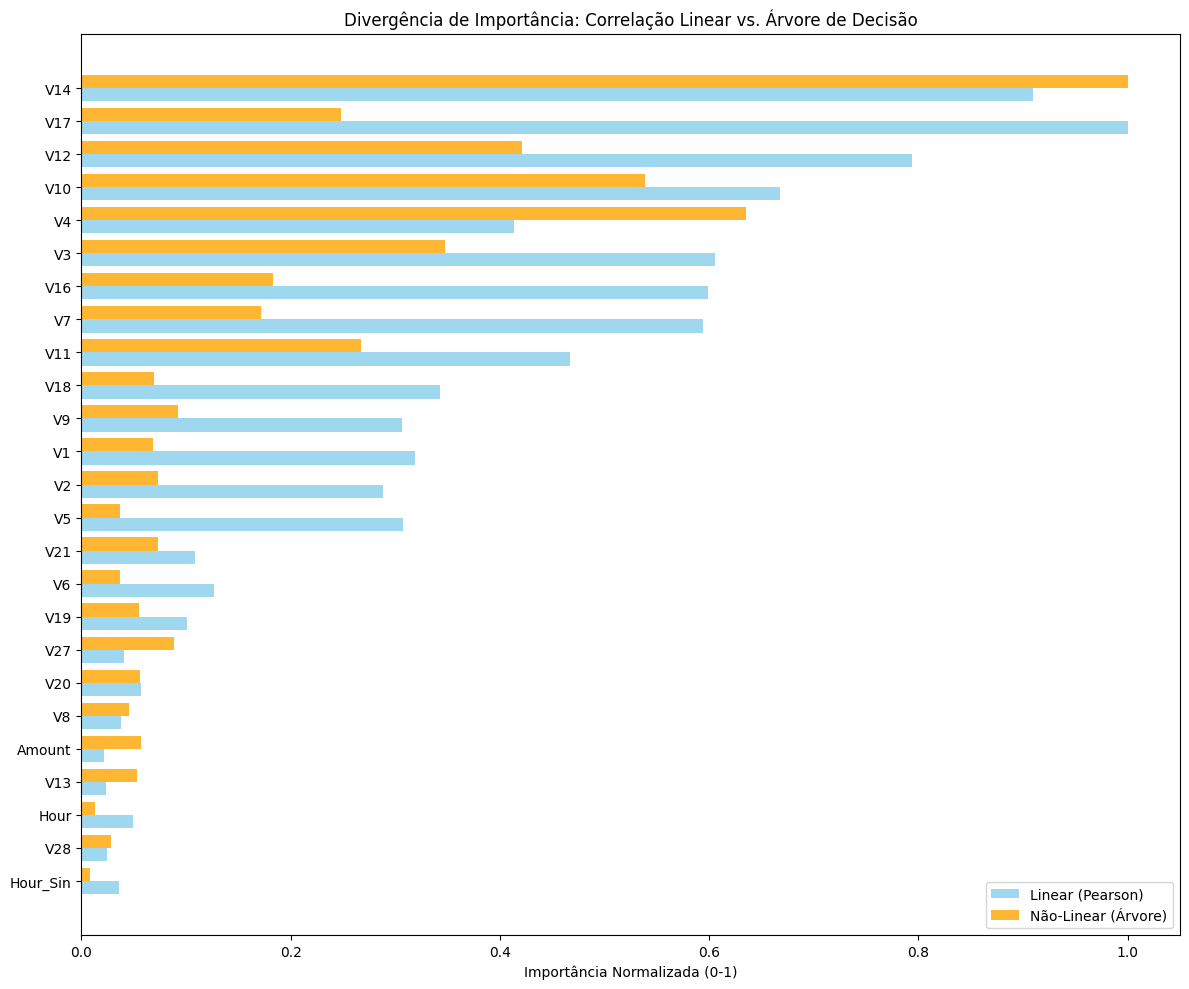


>>> Total de Features Originais: 33
>>> Features Sugeridas para Remoção: 2
>>> Lista de Corte: ['Hour_Sin', 'Amount_Risk_Level']


In [ ]:
# SELEÇÃO DE FEATURES HÍBRIDA (Linear + Não-Linear)

print(">>> Iniciando análise de importância das features...")

# Correlação de Pearson
train_temp = X_train.copy()
train_temp['target'] = y_train

pearson_corr = train_temp.corr()['target'].drop('target').abs()

# (Random Forest)
rf_selector = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)
rf_selector.fit(X_train, y_train)

tree_importance = pd.Series(rf_selector.feature_importances_, index=X_train.columns)


# Cria um DataFrame para comparar os dois métodos
selection_df = pd.DataFrame({
    'Pearson_Corr': pearson_corr,
    'Tree_Importance': tree_importance
})

# Normaliza os valores (0 a 1) para podermos comparar 
selection_df['Pearson_Norm'] = selection_df['Pearson_Corr'] / selection_df['Pearson_Corr'].max()
selection_df['Tree_Norm'] = selection_df['Tree_Importance'] / selection_df['Tree_Importance'].max()

# Cria um Score Combinado 
selection_df['Combined_Score'] = (selection_df['Pearson_Norm'] + selection_df['Tree_Norm']) / 2

selection_df = selection_df.sort_values(by='Combined_Score', ascending=False)

print(selection_df.head(35)[['Pearson_Corr', 'Tree_Importance', 'Combined_Score']])

plt.figure(figsize=(12, 10))
plot_df = selection_df.head(25).sort_values(by='Combined_Score', ascending=True)

width = 0.4
ind = range(len(plot_df))

plt.barh([i - width/2 for i in ind], plot_df['Pearson_Norm'], height=width, label='Linear (Pearson)', color='skyblue', alpha=0.8)
plt.barh([i + width/2 for i in ind], plot_df['Tree_Norm'], height=width, label='Não-Linear (Árvore)', color='orange', alpha=0.8)

plt.yticks(ind, plot_df.index)
plt.title('Divergência de Importância: Correlação Linear vs. Árvore de Decisão')
plt.xlabel('Importância Normalizada (0-1)')
plt.legend()
plt.tight_layout()
plt.show()

cols_to_drop = selection_df[
    (selection_df['Pearson_Norm'] < 0.04) & 
    (selection_df['Tree_Norm'] < 0.015)
].index.tolist()

print(f"\n>>> Total de Features Originais: {X_train.shape[1]}")
print(f">>> Features Sugeridas para Remoção: {len(cols_to_drop)}")
print(f">>> Lista de Corte: {cols_to_drop}")

### 5.2 - Remoção das features que serão descartadas

**A remoção de features limitou-se exclusivamente à variável derivada Amount_Risk_Level. A análise demonstrou que a discretização manual desta variável gerou perda de granularidade, sendo mais eficiente permitir que o algoritmo encontre seus próprios limiares de decisão na variável contínua original (Amount).**

**Em contrapartida, optou-se por manter ambas as transformações cíclicas de tempo (Hour_Sin e Hour_Cos). A preservação do par Seno/Cosseno é fundamental para garantir a representação vetorial correta do ciclo de 24 horas. Remover uma das componentes quebraria a continuidade temporal, prejudicando a capacidade do modelo de capturar padrões de sazonalidade (como fraudes na madrugada) e impactando negativamente a sensibilidade do modelo (Curva ROC).**

In [23]:
cols_to_drop = ['Amount_Risk_Level']
X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)
df_train = df_train.drop(columns=cols_to_drop)
print(f">>> Novo shape do Treino: {X_train.shape}")

>>> Novo shape do Treino: (182276, 32)


## 6 - fazendo as mesmas transformações para o df_test

**Para que o modelo consiga fazer previsões, os dados de teste precisam 'falar a mesma língua' dos dados de treinamento. Por isso, replicamos rigorosamente as mesmas transformações matemáticas no arquivo de teste (df_test): extraímos a hora e o dia e criamos as colunas de seno e cosseno, aplicamos o mesmo escalonamento que foi treinado usando apenas dados de treinamento e por fim removemos as colunas que não são mais nescessárias. Isso garante que a estrutura das colunas seja idêntica à do treino, evitando erros técnicos e assegurando que o algoritmo encontre os padrões que aprendeu a identificar.**

###  6.1 - Transformação Cíclica de Hora (Hour_Sin e Hour_Cos)

In [24]:
if 'Time' in df_test.columns:
    df_test['Hour'] = df_test['Time'].apply(lambda x: np.floor(x / 3600) % 24)

if 'Hour' in df_test.columns:
    df_test['Hour_Sin'] = np.sin(2 * np.pi * df_test['Hour'] / 24)
    df_test['Hour_Cos'] = np.cos(2 * np.pi * df_test['Hour'] / 24)

### 6.2 - Escalonamento Robusto (USANDO O SCALER JÁ AJUSTADO NO TREINO)

In [25]:
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

### 6.3 - Remoção de colunas originais e auxiliares

In [ ]:
if 'id' in df_test.columns:
    test_ids = df_test['id']
    df_test = df_test.drop(columns=['id'])

if 'Time' in df_test.columns:
    df_test = df_test.drop(columns=['Time'])
    
print("Transformações aplicadas ao df_test com sucesso.")
df_test.info()

Transformações aplicadas ao df_test com sucesso.
<class 'pandas.DataFrame'>
RangeIndex: 56962 entries, 0 to 56961
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V1        56962 non-null  float64
 1   V2        56962 non-null  float64
 2   V3        56962 non-null  float64
 3   V4        56962 non-null  float64
 4   V5        56962 non-null  float64
 5   V6        56962 non-null  float64
 6   V7        56962 non-null  float64
 7   V8        56962 non-null  float64
 8   V9        56962 non-null  float64
 9   V10       56962 non-null  float64
 10  V11       56962 non-null  float64
 11  V12       56962 non-null  float64
 12  V13       56962 non-null  float64
 13  V14       56962 non-null  float64
 14  V15       56962 non-null  float64
 15  V16       56962 non-null  float64
 16  V17       56962 non-null  float64
 17  V18       56962 non-null  float64
 18  V19       56962 non-null  float64
 19  V20       56962 non-null  flo

## 7 - Salvando os dados transformados

**Concluímos a preparação dos dados salvando os arquivos processados, que servirão de entrada direta para a etapa de treinamento dos modelos. Esta organização garante integridade e agilidade, dividindo os dados em:**

* **`X_train.csv` e `X_val.csv`:** Contêm as variáveis explicativas (*features*) já transformadas e normalizadas, usadas para ensinar e validar o modelo.
* **`y_train.csv` e `y_val.csv`:** Contêm a coluna alvo (*'Class'*), servindo como o gabarito que indica se a transação é fraude (1) ou normal (0).
* **`X_test_final.csv`:** É o conjunto de teste oficial do Kaggle, agora com as mesmas colunas de engenharia de recursos do treino, pronto para gerar as previsões finais.

In [ ]:
path_dados = '../data/'

# Salvar os DataFrames completos que sofreram transformações

df_train.to_csv(os.path.join(path_dados, 'df_train_processed.csv'), index=False)
df_test.to_csv(os.path.join(path_dados, 'df_test_processed.csv'), index=False)

# Criando o DataFrame final de teste com as mesmas colunas do treino
X_test_final = df_test.copy()
cols_train = X_train.columns.tolist()
X_test_final = X_test_final[cols_train]

# Salvar os conjuntos de Treino e Validação e escalonados
X_train.to_csv(os.path.join(path_dados, 'X_train.csv'), index=False)
X_val.to_csv(os.path.join(path_dados, 'X_val.csv'), index=False)
y_train.to_csv(os.path.join(path_dados, 'y_train.csv'), index=False)
y_val.to_csv(os.path.join(path_dados, 'y_val.csv'), index=False)
X_test_final.to_csv(os.path.join(path_dados, 'X_test_final.csv'), index=False)

print(f"Arquivos salvos com sucesso na pasta: {path_dados}")

Arquivos salvos com sucesso na pasta: ../data/
